# Using POPCON to Compute Fluxes and Inductances Over Ramp-Up and Flattop in a Time-Indendent Manner

In this notebook a demonstration of the methodology used to calculate an estiamte of the flux
    consumption over the ramp-up for time-independent POPCONs is shown.

In [1]:
%reload_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

from cfspopcon.unit_handling import ureg, Quantity, wraps_ufunc, Unitfull, convert_units
from scipy import constants  # type: ignore[import]
import cfspopcon.named_options

from cfspopcon.algorithms import get_algorithm
from cfspopcon.named_options import Algorithms, InternalInductanceGeometry, SurfaceInductanceCoeffs, VertMagneticFieldEq
from cfspopcon.formulas import calc_vertical_magnetic_field, calc_flux_PF, calc_vertical_field_mutual_inductance


In [2]:
### LOAD DATA ###
input_parameters, algorithm, points  = cfspopcon.read_case("../../example_cases/SPARC_PRD")
dataset = xr.Dataset(input_parameters)

In [3]:
class Machine:
    def __init__(self, B0, R0, a, delta, epsilon, kappa, Ip):
        self.B0      = Quantity(B0, ureg.T)
        self.R0      = Quantity(R0, ureg.m)
        self.a       = Quantity(a, ureg.m)
        self.delta   = Quantity(delta, ureg.dimensionless)
        self.epsilon = Quantity(epsilon, ureg.dimensionless)
        self.kappa   = Quantity(kappa, ureg.dimensionless)
        self.Ip      = Quantity(Ip, ureg.MA)

machine = dict()
machine["SPARCV1D"] = Machine(B0=12.3, R0=1.845, a=0.565, delta=0.55, epsilon=0.565/1.845, kappa=1.7, Ip=8.7)
machine["SPARCV0D"] = Machine(B0=12,   R0=1.65,  a=0.56, delta=0.32,  epsilon=0.56/1.65, kappa=1.8, Ip=7.5)
machine["JT60-SA"]  = Machine(B0=2.72, R0=3.01,  a=1.14, delta=0.57,  epsilon=1.14/3.01, kappa=1.85, Ip=5.5) # https://fire.pppl.gov/iaea06_ftp7_5_matsukawa.pdf
machine["DIII-D"]   = Machine(B0=2.6,  R0=1.66,  a=0.67, delta=0.45,  epsilon=0.67/1.66, kappa=1.76, Ip=1.2) # https://escholarship.org/content/qt78k0v04v/qt78k0v04v_noSplash_c44c701847deffab65024dd9ceff9c59.pdf?t=p15pc5
machine["ITER"]     = Machine(B0=5.3,  R0=6.2,   a=2.0, delta=0.33,   epsilon=2.0/6.2, kappa=1.70, Ip=15.0) # https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=585f5eb3f62f3bd76f3d667c1df357562f54c084
machine["KSTAR"]    = Machine(B0=3.5,  R0=1.8,   a=0.5, delta=0.8,    epsilon=0.5/1.8, kappa=2.0, Ip=2.0) # https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=585f5eb3f62f3bd76f3d667c1df357562f54c084
machine["FIRE"]     = Machine(B0=10.0, R0=2.0,   a=0.525, delta=0.4,  epsilon=0.525/2.0, kappa=1.8, Ip=6.5) # https://fire.pppl.gov/Snowmass_BP/FIRE.pdf
machine["ASDEX-U"]  = Machine(B0=2.5,  R0=1.65,  a=0.5, delta=0.4,    epsilon=0.5/1.65, kappa=1.8, Ip=1.4) # https://www.ipp.mpg.de/16208/einfuehrung
machine["JET"]      = Machine(B0=3.6,  R0=2.96,  a=1.25, delta=0.45,  epsilon=1.25/2.96, kappa=1.68, Ip=5) # https://www.ipp.mpg.de/16701/jet
machine["EAST"]     = Machine(B0=3.5,  R0=1.85,  a=0.45, delta=0.8,   epsilon=0.45/1.85, kappa=2.0, Ip=1.0) # https://iopscience.iop.org/article/10.1088/1009-0630/13/1/01
machine["ALC-CMOD"] = Machine(B0=9.5,  R0=0.64,  a=0.21, delta=0.5,   epsilon=0.21/0.64, kappa=1.8, Ip=2.02) # https://www-internal.psfc.mit.edu/research/alcator/data/fst_cmod.pdf

In [4]:
### UPDATE DATASET and CALCULATE INDUCTANCES and FLUXES FLATTOP###
dataset["major_radius"] = machine["SPARCV1D"].R0
dataset["minor_radius"] = machine["SPARCV1D"].a
dataset["magnetic_field_on_axis"] = machine["SPARCV1D"].B0
dataset["inverse_aspect_ratio"] = machine["SPARCV1D"].epsilon
dataset["areal_elongation"] = machine["SPARCV1D"].kappa
get_algorithm(Algorithms.calc_geometry).update_dataset(dataset, in_place=True)
dataset['internal_inductivity'] = 0.91 # taken from simulation
dataset["internal_inductance_geometry"] = InternalInductanceGeometry.Cylindrical
dataset["surface_inductance_coefficients"] = SurfaceInductanceCoeffs.Barr
dataset["vertical_magnetic_field_equation"] = VertMagneticFieldEq.Barr
dataset["safety_factor_on_axis"] = 1.0
dataset["ejima_coefficient"] = 0.6
dataset['average_electron_density'] = dataset['average_electron_density'].sel(dim_average_electron_density=3)
dataset['average_electron_temp'] = dataset['average_electron_temp'].sel(dim_average_electron_temp=7.3, method="nearest")
dataset['average_ion_temp'] = dataset.get("average_electron_temp")
dataset['ion_density_peaking'] = 1.33
dataset['electron_density_peaking'] = 1.43
dataset['z_effective'] = 1.5
dataset['q_star'] = 3
get_algorithm(Algorithms.calc_beta).update_dataset(dataset, in_place=True)
dataset['beta_poloidal'] = 0.2
get_algorithm(Algorithms.calc_bootstrap_fraction).update_dataset(dataset, in_place=True)
dataset['total_flux_available_from_CS'] = Quantity(35.2, ureg.volt * ureg.second)
get_algorithm(Algorithms.calc_ohmic_power).update_dataset(dataset, in_place=True)
get_algorithm(Algorithms.calc_average_ion_temp).update_dataset(dataset, in_place=True)
get_algorithm(Algorithms.calc_inductances).update_dataset(dataset, in_place=True)
get_algorithm(Algorithms.calc_fluxes).update_dataset(dataset, in_place=True)
R0            = dataset['major_radius']
Ip            = dataset['plasma_current']
a             = dataset['minor_radius']
beta_pol      = dataset['beta_poloidal']
l_int         = dataset['internal_inductivity']
kappaA        = dataset['areal_elongation']

Notice that I have used a custom internal inductivity because the cylindrical `l_i` was seen to differ as much as 46% as compared to the `l_i` calculated by the TSC. Because estimations on the `l_i` tend not to be reliable -- as a true calculation relies on equilibrium reconstruction -- an `l_i` from simulation is recommended.

In [5]:
### READ VALUES FROM DICTIONARY ###

beta_poloidal                = dataset.get("beta_poloidal").item()
internal_inductivity         = dataset.get("internal_inductivity").item()
internal_inductance          = dataset.get("internal_inductance").item()
external_inductance          = dataset.get("external_inductance").item()
vertical_field_mutual_inductance = dataset.get("vertical_field_mutual_inductance").item()
vert_magnetic_field          = dataset.get("vertical_magnetic_field").item()
areal_elongation             = dataset.get("areal_elongation").item()
major_radius                 = dataset.get("major_radius").item()
magnetic_field_on_axis       = dataset.get("magnetic_field_on_axis").item()

loop_voltage         = dataset.get("loop_voltage").item()
inverse_aspect_ratio = dataset.get("inverse_aspect_ratio").item()
plasma_current       = dataset.get("plasma_current").item()
internal_flux        = dataset.get("internal_flux").item()
external_flux        = dataset.get("external_flux").item()
resistive_flux       = dataset.get("resistive_flux").item()
max_flattop_duration = dataset.get("max_flattop_duration").item()
poloidal_field_flux  = dataset.get("poloidal_field_flux").item()
max_flux_for_flattop = dataset.get("max_flux_for_flattop").item()

In [6]:
print()
print("beta_poloidal:                    ", beta_poloidal)
print("internal_inductivity:              ", internal_inductivity)
print("internal_inductance:              ", internal_inductance)
print("external_inductance:              ", external_inductance)
print("vertical_field_mutual_inductance: ", vertical_field_mutual_inductance)
print("vertical_magnetic_field:          ", convert_units(vert_magnetic_field, ureg.T))
print("areal_elongation:                 ", areal_elongation)
print("major_radius:                     ", major_radius)
print("inverse_aspect_ratio  ", inverse_aspect_ratio)
print("plasma_current:       ", plasma_current)
print("internal_flux:        ", internal_flux)
print("external_flux:        ", external_flux)
print("resistive_flux:       ", resistive_flux)
print("loop_voltage:         ", loop_voltage)
print("max_flattop_duration: ", max_flattop_duration)
print("magnetic_field_on_axis: ", magnetic_field_on_axis)
print("poloidal_field_flux:        ", poloidal_field_flux)
R0            = dataset['major_radius']
Ip            = dataset['plasma_current']
print("Total Flux Consumed Over Ramp-Up:                    ", internal_flux + external_flux + resistive_flux)
print("Total Flux Consumed Over Ramp-Up with Rule of Thumb: ", (2e-6*R0*Ip).item().magnitude, " weber")
print("Max Flux for Flattop: ", max_flux_for_flattop)


beta_poloidal:                     0.2
internal_inductivity:               0.91 dimensionless
internal_inductance:               1.054915397723187e-06 henry
external_inductance:               2.726593701650873e-06 henry
vertical_field_mutual_inductance:  1.0290112526513495 dimensionless
vertical_magnetic_field:           1.1001740558093238 tesla
areal_elongation:                  1.7 dimensionless
major_radius:                      1.845 meter
inverse_aspect_ratio   0.3062330623306233 dimensionless
plasma_current:        8700000.0 ampere
internal_flux:         9.177763960191728 weber
external_flux:         23.721365204362595 weber
resistive_flux:        12.102545881571507 weber
loop_voltage:          0.2578032204829447 volt
max_flattop_duration:  8.940846903401333 second
magnetic_field_on_axis:  12.3 tesla
poloidal_field_flux:         12.106654171667651 weber
Total Flux Consumed Over Ramp-Up:                     45.00167504612583 weber
Total Flux Consumed Over Ramp-Up with Rule of Thu

The assumption here is that at t=0 the flux-consuming terms are 0 webers and so the flux value at flattop is
a reasonable estimate on the change in flux over the ramp-up.

The poloidal flux is included in the estimate for total flux since this function gives the instantaneous flux contribution from the poloidal field coils to the LCFS of the plasma via the vertical field to maintain the toroidal force balance.

We can now do the same calculation of flux consumed over the ramp-up for various machines and compare the method used above with a Rule of Thumb (ROT) and a method employed by `Sugihara`. Choosing a `beta_poloidal` of 0.2 for simplicity across all machines we have...

In [7]:
def calc_flux_rampup_Sugihara(kappa:float, R:float, a:float, Ip:float) -> float:
    R = R.item().magnitude
    kappa = kappa.item().magnitude
    a = a.item().magnitude
    Ip = Ip.item().magnitude
    A = R/a
    flux_Ind = constants.mu_0*A*a*(np.log(8*A)-1.6)*(Ip*1e6)
    flux_Res = 3.78e-6*(kappa**(0.2))*((R)/((a)**0.8))*((Ip*1e6)**0.8)
    return flux_Res + flux_Ind

def calc_flux_rampup_ROT(R:float, Ip:float) -> float:
    return (2 * R.item().magnitude * Ip.item().magnitude)

def reltol (other, poynt):
    return '{:g}'.format(float('{:.{p}g}'.format(100 * np.abs(other-poynt)/other, p=3)))

We have defined an object `Machine` with the various machines and a `DataArray` with the various methods for calculating the flux over the ramp up. Note that the Sugihara method does not explicitly take into account the flux contribution from the vertical field created by the PFCs.

In [8]:
flux_methods_over_machines = xr.DataArray(
    dims=["machine", "flux_method"],
    coords=dict(
        machine=["ALC-CMOD", "ASDEX-U", "DIII-D", "EAST", "FIRE", "ITER", "JET", "JT60-SA", "KSTAR", "SPARCV1D", "SPARCV0D"],
        flux_method=["Hirsh&MitTaka13", "Hirsh&Barr", "Hirsh&Jean", "Hirsh&MFEF", "Barr&Barr", "ROT", "Sugihara"],
    ),
)
PF_flux_over_machines = flux_methods_over_machines.copy(deep=True)

In [9]:
###***Assumed parameters across all machines***###
dataset["beta_poloidal"] = 0.1 
dataset["internal_inductance_geometry"] = InternalInductanceGeometry.Cylindrical
dataset["loop_voltage"] = 0.5 * ureg.volts  # N/A for this calc since not considering flattop
dataset["elongation_ratio_sep_to_areal"] = 1
dataset["triangularity_ratio_sep_to_psi95"] = 1
dataset["ejima_coefficient"] = 0.6
dataset["internal_inductivity"] = 0.91
dataset["total_flux_available_from_CS"] = 0 * ureg.weber  # N/A for these calcs

# dictionary of the various flux calculation methods to make iterating easier
external_flux_method_dict = {
    "Hirsh&MitTaka13": (SurfaceInductanceCoeffs.Hirshman, VertMagneticFieldEq.Mit_and_Taka_Eq13),
    "Hirsh&Barr": (SurfaceInductanceCoeffs.Hirshman, VertMagneticFieldEq.Barr),
    "Hirsh&Jean": (SurfaceInductanceCoeffs.Hirshman, VertMagneticFieldEq.Jean),
    "Hirsh&MFEF": (SurfaceInductanceCoeffs.Hirshman, VertMagneticFieldEq.MgnticFsionEnrgyFrmlry),
    "Barr&Barr": (SurfaceInductanceCoeffs.Barr, VertMagneticFieldEq.Barr),
    "ROT": (SurfaceInductanceCoeffs.Hirshman, VertMagneticFieldEq.MgnticFsionEnrgyFrmlry),
    "Sugihara": (SurfaceInductanceCoeffs.Barr, VertMagneticFieldEq.Barr),
}

import warnings
warnings.filterwarnings('ignore') # ignore unit strip warning happening with Sugihara and ROT functions
###***RUN CALCULATIONS***###
for machine_name in machine:
    for external_flux_method in external_flux_method_dict:
        if external_flux_method != "ROT" and external_flux_method != "Sugihara":
            dataset["magnetic_field_on_axis"] = machine[machine_name].B0
            dataset["major_radius"] = machine[machine_name].R0
            dataset["minor_radius"] = machine[machine_name].a
            dataset["triangularity_psi95"] = machine[machine_name].delta
            dataset["areal_elongation"] = machine[machine_name].kappa
            dataset["inverse_aspect_ratio"] = machine[machine_name].epsilon
            dataset["plasma_current"] = machine[machine_name].Ip
            dataset["surface_inductance_coefficients"] = external_flux_method_dict[external_flux_method][0]
            dataset["vertical_magnetic_field_equation"] = external_flux_method_dict[external_flux_method][1]
            get_algorithm(Algorithms.calc_geometry).update_dataset(dataset, in_place=True)
            get_algorithm(Algorithms.calc_inductances).update_dataset(dataset, in_place=True)
            get_algorithm(Algorithms.calc_fluxes).update_dataset(dataset, in_place=True)
            # STORE VALUES
            PF_flux_over_machines.loc[dict(machine=machine_name, flux_method=external_flux_method)] = dataset["poloidal_field_flux"]
            if machine_name == "SPARCV1D":
                SPARCV1D_external_flux = dataset.get("external_flux").item()
                SPARCV1D_internal_flux = dataset.get("internal_flux").item()
                SPARCV1D_resistive_flux = dataset.get("resistive_flux").item()
                SPARCV1D_PF_flux = dataset.get("poloidal_field_flux").item()
                print(
                    external_flux_method,
                    ": ",
                    "SPARCV1D_resistive_flux ",
                    SPARCV1D_resistive_flux,
                    "SPARCV1D_external_flux ",
                    SPARCV1D_external_flux,
                    "SPARCV1D_internal_flux ",
                    SPARCV1D_internal_flux,
                    "SPARCV1D_PF_flux ",
                    SPARCV1D_PF_flux,
                    "flux_needed_from_CS_for_ramp",
                    dataset.get("flux_needed_from_CS_over_rampup").item(),
                )
            flux_methods_over_machines.loc[dict(machine=machine_name, flux_method=external_flux_method)] = dataset[
                "flux_needed_from_CS_over_rampup"
            ]
        elif external_flux_method == "ROT":
            ROT_flux = calc_flux_rampup_ROT(dataset.get("major_radius"), dataset.get("plasma_current"))
            flux_methods_over_machines.loc[dict(machine=machine_name, flux_method=external_flux_method)] = (
                ROT_flux * ureg.weber
            )
        elif external_flux_method == "Sugihara":
            Sugihara_flux = calc_flux_rampup_Sugihara(
                dataset.get("areal_elongation"), dataset.get("major_radius"), dataset.get("minor_radius"), dataset.get("plasma_current")
            )
            flux_methods_over_machines.loc[dict(machine=machine_name, flux_method=external_flux_method)] = Sugihara_flux * ureg.weber

Hirsh&MitTaka13 :  SPARCV1D_resistive_flux  12.102545881571507 weber SPARCV1D_external_flux  18.519976040873026 weber SPARCV1D_internal_flux  9.177763960191728 weber SPARCV1D_PF_flux  7.5261165776053005 weber flux_needed_from_CS_for_ramp 32.27416930503096 weber
Hirsh&Barr :  SPARCV1D_resistive_flux  12.102545881571507 weber SPARCV1D_external_flux  18.519976040873026 weber SPARCV1D_internal_flux  9.177763960191728 weber SPARCV1D_PF_flux  7.495799244334044 weber flux_needed_from_CS_for_ramp 32.304486638302215 weber
Hirsh&Jean :  SPARCV1D_resistive_flux  12.102545881571507 weber SPARCV1D_external_flux  18.519976040873026 weber SPARCV1D_internal_flux  9.177763960191728 weber SPARCV1D_PF_flux  7.781319888685929 weber flux_needed_from_CS_for_ramp 32.01896599395033 weber
Hirsh&MFEF :  SPARCV1D_resistive_flux  12.102545881571507 weber SPARCV1D_external_flux  18.519976040873026 weber SPARCV1D_internal_flux  9.177763960191728 weber SPARCV1D_PF_flux  8.787145773766918 weber flux_needed_from_CS_fo

['ALC-CMOD' 'ASDEX-U' 'DIII-D' 'EAST' 'FIRE' 'ITER' 'JET' 'JT60-SA'
 'KSTAR' 'SPARCV1D' 'SPARCV0D']


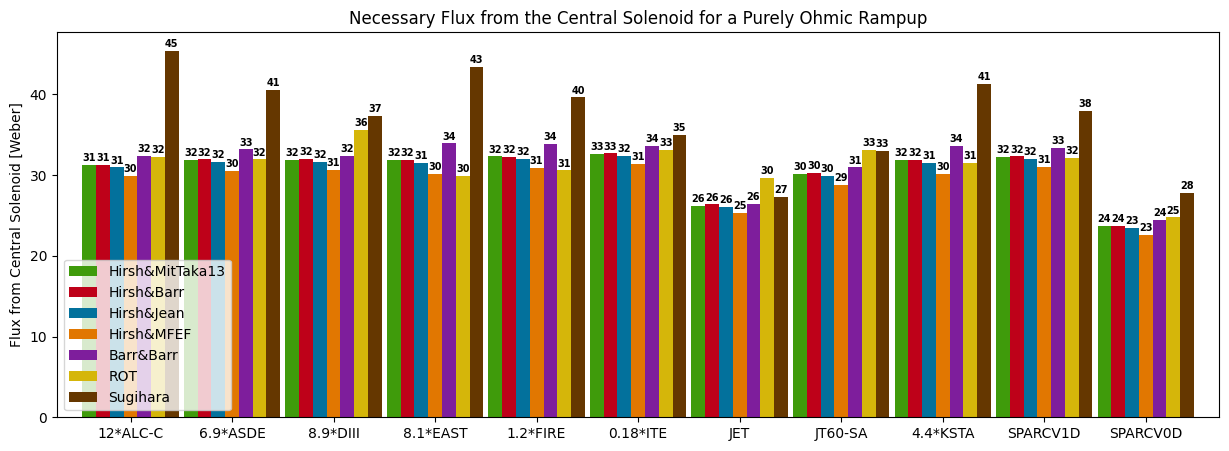

In [10]:
###***Scaling other machines to create a clearer bar plot***###

machine_name = flux_methods_over_machines.coords['machine'].values
scaled_machine_name = machine_name.copy()
print(scaled_machine_name)

scaling_factor_ITER =  flux_methods_over_machines.loc[dict(machine="SPARCV1D")] / flux_methods_over_machines.loc[dict(machine="ITER")]
scaling_factor_CMOD =  flux_methods_over_machines.loc[dict(machine="SPARCV1D")] / flux_methods_over_machines.loc[dict(machine="ALC-CMOD")]
scaling_factor_AUG =   flux_methods_over_machines.loc[dict(machine="SPARCV1D")] / flux_methods_over_machines.loc[dict(machine="ASDEX-U")]
scaling_factor_DIIID = flux_methods_over_machines.loc[dict(machine="SPARCV1D")] / flux_methods_over_machines.loc[dict(machine="DIII-D")]
scaling_factor_EAST =  flux_methods_over_machines.loc[dict(machine="SPARCV1D")] / flux_methods_over_machines.loc[dict(machine="EAST")]
scaling_factor_FIRE =  flux_methods_over_machines.loc[dict(machine="SPARCV1D")] / flux_methods_over_machines.loc[dict(machine="FIRE")]
scaling_factor_KSTAR = flux_methods_over_machines.loc[dict(machine="SPARCV1D")] / flux_methods_over_machines.loc[dict(machine="KSTAR")]

scaled_machine_name[5] = str("{:.2g}".format(scaling_factor_ITER.mean().values)) + "*" + scaled_machine_name[5]
scaled_machine_name[0] = str("{:.2g}".format(scaling_factor_CMOD.mean().values)) + "*" + scaled_machine_name[0]
scaled_machine_name[1] = str("{:.2g}".format(scaling_factor_AUG.mean().values)) + "*" + scaled_machine_name[1]
scaled_machine_name[2] = str("{:.2g}".format(scaling_factor_DIIID.mean().values)) + "*" + scaled_machine_name[2]
scaled_machine_name[3] = str("{:.2g}".format(scaling_factor_EAST.mean().values)) + "*" + scaled_machine_name[3]
scaled_machine_name[4] = str("{:.2g}".format(scaling_factor_FIRE.mean().values)) + "*" + scaled_machine_name[4]
scaled_machine_name[8] = str("{:.2g}".format(scaling_factor_KSTAR.mean().values)) + "*" + scaled_machine_name[8]

flux_methods_over_machines.loc[dict(machine="ITER")] = scaling_factor_ITER.mean() * flux_methods_over_machines.loc[dict(machine="ITER")]
flux_methods_over_machines.loc[dict(machine="ALC-CMOD")] = scaling_factor_CMOD.mean() * flux_methods_over_machines.loc[dict(machine="ALC-CMOD")]
flux_methods_over_machines.loc[dict(machine="ASDEX-U")] = scaling_factor_AUG.mean() * flux_methods_over_machines.loc[dict(machine="ASDEX-U")]
flux_methods_over_machines.loc[dict(machine="DIII-D")] = scaling_factor_DIIID.mean() * flux_methods_over_machines.loc[dict(machine="DIII-D")]
flux_methods_over_machines.loc[dict(machine="EAST")] = scaling_factor_EAST.mean() * flux_methods_over_machines.loc[dict(machine="EAST")]
flux_methods_over_machines.loc[dict(machine="FIRE")] = scaling_factor_FIRE.mean() * flux_methods_over_machines.loc[dict(machine="FIRE")]
flux_methods_over_machines.loc[dict(machine="KSTAR")] = scaling_factor_KSTAR.mean() * flux_methods_over_machines.loc[dict(machine="KSTAR")]
flux_methods_over_machines = flux_methods_over_machines.assign_coords(machine=scaled_machine_name)

###***PLOTTING_needed_CS_flux_over_rampup***###
df = pd.DataFrame(
    {
        "Hirsh&MitTaka13": flux_methods_over_machines.sel(machine=scaled_machine_name, flux_method="Hirsh&MitTaka13"),
        "Hirsh&Barr": flux_methods_over_machines.sel(machine=scaled_machine_name, flux_method="Hirsh&Barr"),
        "Hirsh&Jean": flux_methods_over_machines.sel(machine=scaled_machine_name, flux_method="Hirsh&Jean"),
        "Hirsh&MFEF": flux_methods_over_machines.sel(machine=scaled_machine_name, flux_method="Hirsh&MFEF"),
        "Barr&Barr": flux_methods_over_machines.sel(machine=scaled_machine_name, flux_method="Barr&Barr"),
        "ROT": flux_methods_over_machines.sel(machine=scaled_machine_name, flux_method="ROT"),
        "Sugihara": flux_methods_over_machines.sel(machine=scaled_machine_name, flux_method="Sugihara"),
    },
    index=scaled_machine_name,
)

ax = df.plot.bar(
    figsize=(15, 5),
    rot=0,
    width=0.95,
    color={
        "Hirsh&MitTaka13": "xkcd:grass green",
        "Hirsh&Barr": "xkcd:scarlet",
        "Hirsh&Jean": "xkcd:ocean blue",
        "Hirsh&MFEF": "xkcd:pumpkin",
        "Barr&Barr": "xkcd:purple",
        "ROT": "xkcd:dark yellow",
        "Sugihara": "xkcd:brown",
    },
)
for p in ax.patches:
    label = "{:.2g}".format(p.get_height())  # Round to two decimal places
    ax.annotate(
        str(label),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        fontsize=7,
        xytext=(0, 5),
        textcoords="offset points",
        color="black",
        weight="bold",
    )
ax.set_ylabel("Flux from Central Solenoid [Weber]")
ax.set_title("Necessary Flux from the Central Solenoid for a Purely Ohmic Rampup")
ax.legend(loc="lower left")
plt.savefig("/Users/isaacsavona/Documents/CFS/FluxConsump/NewPlots/ROTSugPoynt@RampUp.svg", format="svg")
plt.show()

Note that the poynting method is significantly lower than the Rule of Thumb (ROT) and the Sugihara method, because it explicitly takes into account the flux contribution from the vertical field created by the poloidal field coils.

It is also possible to make a typical `POPCON` plot where the maximum flattop time can be seen in operation space.

In [11]:
### LOAD DATA ###
input_parameters, algorithm, points  = cfspopcon.read_case("../../example_cases/SPARC_PRD")
dataset = xr.Dataset(input_parameters)

The parameters are different here than they were at the beginning of the notebook (e.g., `beta_poloidal` is computed through `POPCON`) so therefoere the flattop times are different.

In [12]:
### UPDATE DATASET and CALCULATE INDUCTANCES and FLUXES FLATTOP###
dataset['internal_inductivity'] = 1 # inspired by simulation
dataset["internal_inductance_geometry"] = InternalInductanceGeometry.Cylindrical
dataset["surface_inductance_coefficients"] = SurfaceInductanceCoeffs.Barr
dataset["vertical_magnetic_field_equation"] = VertMagneticFieldEq.Barr
dataset["safety_factor_on_axis"] = 1.0 # during flattop
dataset["ejima_coefficient"] = 0.6
dataset['total_flux_available_from_CS'] = Quantity(35, ureg.volt * ureg.second) # CS available flux minus 2Wb at beginning of flattop
algorithm.update_dataset(dataset, in_place=True)

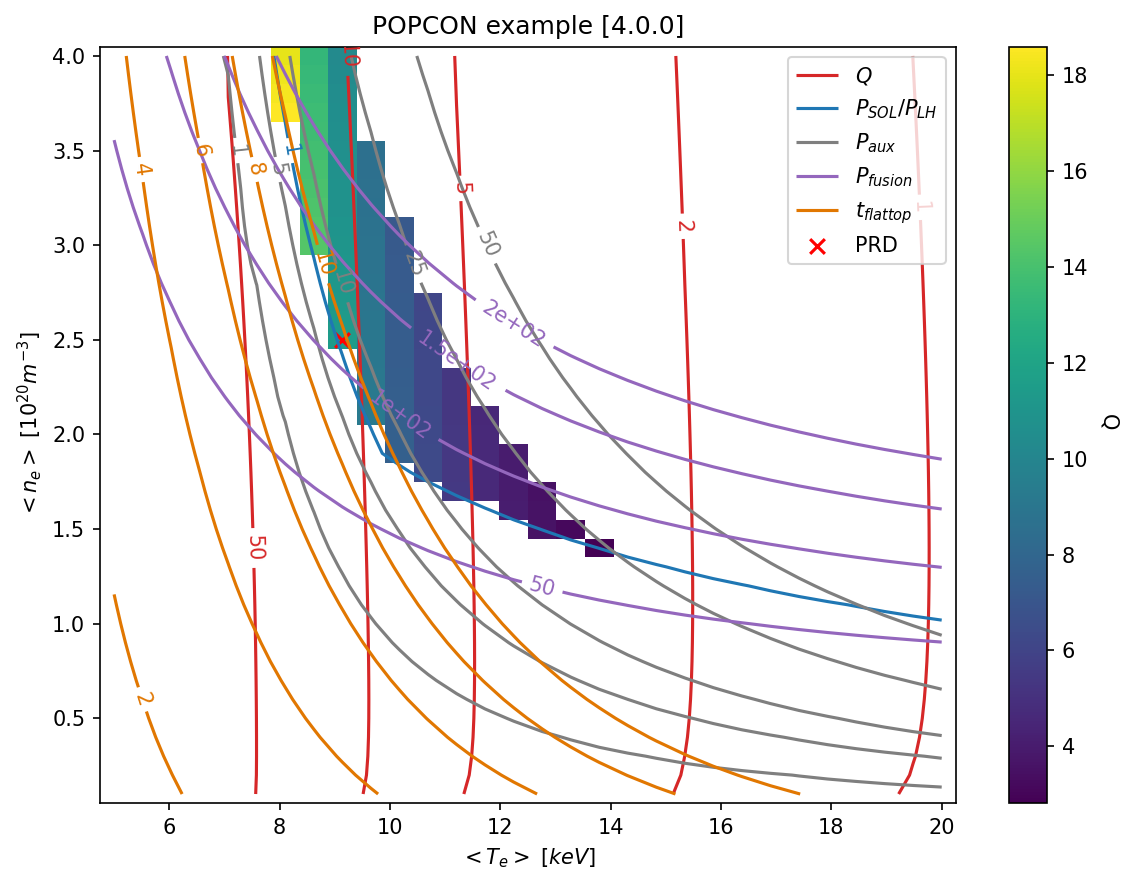

In [13]:
plot_style = cfspopcon.read_plot_style("../../example_cases/SPARC_PRD/plot_popcon.yaml")

cfspopcon.plotting.make_plot(
    dataset,
    plot_style,
    points=points,
    title="POPCON example",
    output_dir=None
)